### This program can be used to create a structured df from the Patient's notes data

Importing all necessary libraries

In [246]:
# All necessary imports
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

from time import time
import numpy as np

import os
from sklearn.utils import resample
import re

from sklearn.decomposition import PCA
from sklearn.manifold import (
    TSNE,
    Isomap,
    LocallyLinearEmbedding,
)
import umap

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

import plotly.express as px

from sklearn import metrics
import warnings
warnings.simplefilter(action='ignore')


Reading in the data

In [247]:

patient = pd.read_csv("patient_notes.csv")
print(f"Original data shape: {patient.shape}")
n = 10000

patient = resample(patient, n_samples=n)
print(f"Sample data shape: {patient.shape}")
patient.head()

Original data shape: (42146, 3)
Sample data shape: (10000, 3)


,pn_num,case_num,pn_history
38011,91054,9,Ms. Madden is a 22 yo F who presents with head...
37545,90573,9,20 year old female presents with sudden onset ...
39383,92474,9,20 yo F who presents for sever headache. she ...
13772,38903,3,"a 35-year-old male, has come to the physician'..."
34179,81447,8,67 year old female c/o of fatigue and difficul...


Cleaning html tags, emails, numbers, and punctuation from the patient notes.

In [248]:
# ---------------------------------------------------------------
# Downloading necessary NLTK resources needed for preprocessing
# ---------------------------------------------------------------

# -------------------------
# Text Cleaning Function
# -------------------------
def clean_text(text):
    # Removing HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Removing emails
    text = re.sub(r'\S+@\S+', '', text)

    # Removing numbers
    text = re.sub(r'\d+', '', text)

    # Removing punctuation
    text = re.sub(r'[^\w\s]', '', text)

    return text


# -------------------------
# # Cleaning the text in the column
# -------------------------
patient["pn_history_clean"] = patient["pn_history"].apply(clean_text)

patient.head()

,pn_num,case_num,pn_history,pn_history_clean
38011,91054,9,Ms. Madden is a 22 yo F who presents with head...,Ms Madden is a yo F who presents with headach...
37545,90573,9,20 year old female presents with sudden onset ...,year old female presents with sudden onset wo...
39383,92474,9,20 yo F who presents for sever headache. she ...,yo F who presents for sever headache she sta...
13772,38903,3,"a 35-year-old male, has come to the physician'...",a yearold male has come to the physicians offi...
34179,81447,8,67 year old female c/o of fatigue and difficul...,year old female co of fatigue and difficulty ...


Instantiating the stemmer and lemmatizer and downloading the stop words used

In [249]:
# ---------------------------------------------------------------------------------
# Tokenization, Lowercasing, Stop Words Removal, Stemming, and Lemmatization
# ---------------------------------------------------------------------------------

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
porter = PorterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/btwitchell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/btwitchell/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/btwitchell/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Applying the stop word removal, stemming, and lemmatization to the dataset. Also tokenizing the documents by word.

In [250]:
def process_text(text):
    """
    This function processes the given text by performing tokenization, lowercasing, stop words removal, stemming, and lemmatization.

    Parameters:
    - text: The input text to be processed.

    Returns:
    - processed_text: The processed text after tokenization, lowercasing, stop words removal, stemming, and lemmatization.
    """
    # Tokenization and Lowercasing (puts words into a list delimited by spaces and newlines)
    tokens = nltk.word_tokenize(text.lower())
    
    # Stop Words Removal
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    # Stemming and Lemmatization
    stemmed = [porter.stem(word) for word in filtered_tokens]
    lemmatized = [lemmatizer.lemmatize(word) for word in stemmed]
    processed_text = ' '.join(lemmatized)

    return processed_text

# ---------------------------------------------------------------------------------
# Apply processing
# ---------------------------------------------------------------------------------
patient["pn_history_preprocessed"] = patient["pn_history_clean"].apply(process_text)
patient

,pn_num,case_num,pn_history,pn_history_clean,pn_history_preprocessed
38011,91054,9,Ms. Madden is a 22 yo F who presents with head...,Ms Madden is a yo F who presents with headach...,m madden yo f present headach pain sudden onse...
37545,90573,9,20 year old female presents with sudden onset ...,year old female presents with sudden onset wo...,year old femal present sudden onset worsein he...
39383,92474,9,20 yo F who presents for sever headache. she ...,yo F who presents for sever headache she sta...,yo f present sever headach state worst headach...
13772,38903,3,"a 35-year-old male, has come to the physician'...",a yearold male has come to the physicians offi...,yearold male come physician offic today stomac...
34179,81447,8,67 year old female c/o of fatigue and difficul...,year old female co of fatigue and difficulty ...,year old femal co fatigu difficulti sleep week...
...,...,...,...,...,...
40355,93480,9,Ms Madden is a 20 year old female presenting w...,Ms Madden is a year old female presenting wit...,m madden year old femal present day hx headach...
4114,21134,2,44 y/o F with 3 year history of irregular peri...,yo F with year history of irregular periods ...,yo f year histori irregular period last day se...
13248,38373,3,Mr Hamilton is a 35 year old male who presents...,Mr Hamilton is a year old male who presents t...,mr hamilton year old male present today compla...
26235,56207,5,26 year old female with heart palpitations. Sh...,year old female with heart palpitations She s...,year old femal heart palpit say episod heart p...


Representing the tokenized words as a TF-IDF matrix, which accounts for frequency of tokens both locally to a document (increasing the importance of the token) aswell as globally for a corpus (decreasing importance of the token).

In [251]:

# ---------------------------------------------------------------------------------
# TF-IDF Vectorization
# ---------------------------------------------------------------------------------

vectorizer = TfidfVectorizer(strip_accents='unicode',max_df=0.5, min_df=5)#ngram_range=(1,1), (2,2), (3,3)
t0 = time()
sparse_tfidf_matrix = vectorizer.fit_transform(patient["pn_history_preprocessed"])
print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {sparse_tfidf_matrix.shape[0]}, n_features: {sparse_tfidf_matrix.shape[1]}")
print(f"sparseness: {sparse_tfidf_matrix.nnz / np.prod(sparse_tfidf_matrix.shape):.3f} of the entries of the TFIDF matrix are non-zero.")

vectorization done in 0.392 s
n_samples: 10000, n_features: 3589
sparseness: 0.017 of the entries of the TFIDF matrix are non-zero.


Apply data reducgion via Latent Semantic Analysis (LSM), which can be conceived of as PCA applied to sparse matrices.

Because the TF-IDF matrix is sparse, I determined (contrary to the assignment's instructions) that outlier detection  could negatively affect the output of truncated Singular Value Decomposition (SVD). Of course, while trying out various methods and obtaining results is more ideal, in the interest and of time and simplicity I omitted this step. Per [Scikit-Learn's guidance for clustering with text documents](https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py) I determined that normalization of the data would be appropriate only after I first obtain the truncated SVD matrix and keeping the first k columns that capture 90% of total variance.

In [252]:

n_components = min(sparse_tfidf_matrix.shape)
svd = TruncatedSVD(n_components=n_components)
    
t0 = time()
X_lsa = svd.fit(sparse_tfidf_matrix)
cumulative_variance = np.cumsum(svd.explained_variance_ratio_)

# Keep first k components that explain 90% of total variance
k = np.where(cumulative_variance >= 0.90)[0][0] + 1
k_singular_values = svd.transform(sparse_tfidf_matrix)[:, :k]

print(f"LSA done in {time() - t0:.3f} s")
print(f"Number of components explaining 90% of variance: {k}")

# normalize the singular values
X = Normalizer(copy=False).fit_transform(k_singular_values)
df = pd.concat([patient[['pn_num','case_num','pn_history']].reset_index(drop=True),pd.DataFrame(X).reset_index(drop=True)], axis=1)
df


LSA done in 55.835 s
Number of components explaining 90% of variance: 1395


,pn_num,case_num,pn_history,0,1,2,3,4,5,6,...,1385,1386,1387,1388,1389,1390,1391,1392,1393,1394
0,91054,9,Ms. Madden is a 22 yo F who presents with head...,0.283425,0.027480,-0.206889,-0.018830,0.433852,-0.062819,-0.003288,...,-0.001176,-0.005150,0.013300,-0.000791,0.005017,-0.010016,-0.005853,0.000936,-0.003150,0.010205
1,90573,9,20 year old female presents with sudden onset ...,0.261359,0.025564,-0.066349,-0.089162,0.110102,-0.057655,-0.025576,...,-0.008010,-0.007986,-0.001206,-0.003133,-0.018694,-0.007643,-0.014022,0.004525,-0.000439,-0.035034
2,92474,9,20 yo F who presents for sever headache. she ...,0.315773,0.024858,-0.227657,-0.028953,0.436337,-0.056138,-0.099211,...,-0.000519,-0.007747,-0.002966,0.013968,-0.008059,0.012510,0.001702,0.003180,0.003926,-0.013020
3,38903,3,"a 35-year-old male, has come to the physician'...",0.330206,0.261606,0.096922,-0.005743,0.007643,-0.009833,0.009929,...,-0.013374,-0.000921,-0.021097,-0.017248,0.000779,-0.008780,0.011592,-0.000594,-0.002803,-0.001832
4,81447,8,67 year old female c/o of fatigue and difficul...,0.294521,-0.210423,-0.207754,0.403663,-0.189688,-0.282189,0.001907,...,-0.009802,0.001956,-0.003870,0.002954,-0.001973,-0.014026,-0.001093,0.003191,0.008281,-0.001050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,93480,9,Ms Madden is a 20 year old female presenting w...,0.337411,-0.006025,-0.165570,-0.085691,0.363212,-0.049234,-0.095074,...,-0.006174,0.004364,-0.002402,0.007756,-0.003483,-0.001741,-0.005263,-0.005776,0.000356,-0.000558
9996,21134,2,44 y/o F with 3 year history of irregular peri...,0.257307,-0.208208,0.210125,0.076772,0.030029,0.021491,-0.004776,...,0.011783,-0.021718,0.001725,-0.026295,0.011269,0.007540,0.007853,-0.023147,0.010442,-0.009690
9997,38373,3,Mr Hamilton is a 35 year old male who presents...,0.301229,0.324679,0.061749,0.042420,-0.043247,0.002519,-0.010401,...,-0.004704,-0.014679,-0.009217,0.006273,-0.003801,0.005471,-0.002268,-0.011090,0.011316,-0.002285
9998,56207,5,26 year old female with heart palpitations. Sh...,0.285748,-0.135667,-0.027415,-0.210524,-0.158043,-0.029994,-0.022046,...,0.008904,0.009395,0.011050,0.000856,0.013315,0.018572,-0.004484,-0.007268,-0.000250,-0.016288


## Manifold techniques

I used various manifold techniques to again perform dimension reduction, representing the data in 2, 3, and 4 dimensions. 

In [253]:

def embeddings_dict_n_components(n_components=2, n_neighbors=30, n_jobs=-1):
    """Returns a dictionary of embeddings with n components
    Embeddings used are PCA, t-SNE, Isomap, LLE, Modified LLE, & UMAP
    """
    embeddings = {
        f"PCA_{n_components}_comp": PCA(
                                        n_components=n_components,
                                        random_state=42,
                                        ),
        f"t-SNE_{n_components}_comp": TSNE(
                                        n_components=n_components,
                                        n_iter=500,
                                        n_iter_without_progress=150,
                                        random_state=42,
                                        method='exact',
                                        n_jobs=n_jobs
                                        ),
        f"Isomap_{n_components}_comp": Isomap(n_neighbors=n_neighbors,
                                             n_components=n_components,
                                             n_jobs=n_jobs),
        f"Stand-LLE_{n_components}_comp": LocallyLinearEmbedding(
                                                        n_neighbors=n_neighbors,
                                                        n_components=n_components,
                                                        method="standard",
                                                        n_jobs=n_jobs
                                                        ),
        f"Mod-LLE_{n_components}_comp": LocallyLinearEmbedding(
                                            n_neighbors=n_neighbors,
                                            n_components=n_components,
                                            method="modified",
                                            n_jobs=n_jobs
                                            ),
        f"HessianLLE_{n_components}_comp": LocallyLinearEmbedding(
                                                        n_neighbors=n_neighbors,
                                                        n_components=n_components,
                                                        method="hessian",
                                                        eigen_solver='dense',
                                                        n_jobs=n_jobs
                                                        ),
        f"UMAP_{n_components}_comp": umap.UMAP(
                                                n_neighbors=n_neighbors,
                                                n_components=n_components,)
    }
    return embeddings

embeddings = []
dimensions_upper_bound = 4
for n_comp in range(2,dimensions_upper_bound+1):
    embeddings.append(embeddings_dict_n_components(n_components=n_comp))



The 2 and 3 dimension representations are then plotted to show how well each technique was able to separate the data. The original labels for the patiet's case were used to color the datapoints, and the data for almost all the techniques are separated according to these labels.

It's important to note that the goal with these unsupervised methods is not necessarily to separate the data according to these labels, as other types of groupings could prove to provide useful information. However, it is also helpful to see that LSM combined with these various embeddings performed very well in separating the data according to the pre-defined cases.

In [254]:

def plot_embeddings(X, y, title, axes, dimensions=2, shorten_axes_labels=True):
    """Plot the embedding with either 2 or 3 dimensions"""
    y=y.astype(str)
    height = 400
    width = 500

    if shorten_axes_labels:
        for i in range(len(axes)):
            axes[i] = axes[i][-3:]

    if dimensions == 2:
        fig = px.scatter(x=X[0], y=X[1], color=y, title=title)
        fig.update_layout(width=width,height=height,xaxis_title=axes[0],yaxis_title=axes[1])

    if dimensions == 3:
        fig = px.scatter_3d(x=X[0], y=X[1], z=X[2],color=y, title=title)
        fig.update_layout(scene = dict(xaxis_title=axes[0],yaxis_title=axes[1],zaxis_title=axes[2]),
                          width=width,height=height)
    
    return fig


In [255]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_embeddings(X, y, title, axes, dimensions=2, shorten_axes_labels=True):
    """Plot the embedding with either 2 or 3 dimensions using matplotlib"""
    # y = y.astype(str)
    fig = plt.figure()

    if shorten_axes_labels:
        for i in range(len(axes)):
            axes[i] = axes[i][-3:]

    if dimensions == 2:
        ax = fig.add_subplot(1, 1, 1)
        scatter = ax.scatter(X[0], X[1], c=y)
        ax.set_title(title)
        ax.set_xlabel(axes[0])
        ax.set_ylabel(axes[1])
        legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
        ax.add_artist(legend1)

    elif dimensions == 3:
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(X[0], X[1], X[2], c=y)
        ax.set_title(title)
        ax.set_xlabel(axes[0])
        ax.set_ylabel(axes[1])
        ax.set_zlabel(axes[2])
        legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
        ax.add_artist(legend1)

    return ax


Fitting PCA_2_comp...Done ✔️
Fitting t-SNE_2_comp...Done ✔️
Fitting Isomap_2_comp...Done ✔️
Fitting Stand-LLE_2_comp...Done ✔️
Fitting Mod-LLE_2_comp...Done ✔️
Fitting HessianLLE_2_comp...Done ✔️
Fitting UMAP_2_comp...Done ✔️
Fitting PCA_3_comp...Done ✔️
Fitting t-SNE_3_comp...Done ✔️
Fitting Isomap_3_comp...Done ✔️
Fitting Stand-LLE_3_comp...Done ✔️
Fitting Mod-LLE_3_comp...Done ✔️
Fitting HessianLLE_3_comp...Done ✔️
Fitting UMAP_3_comp...Done ✔️
Fitting PCA_4_comp...Done ✔️
Fitting t-SNE_4_comp...Done ✔️
Fitting Isomap_4_comp...Done ✔️
Fitting Stand-LLE_4_comp...Done ✔️
Fitting Mod-LLE_4_comp...Done ✔️
Fitting HessianLLE_4_comp...Done ✔️
Fitting UMAP_4_comp...Done ✔️


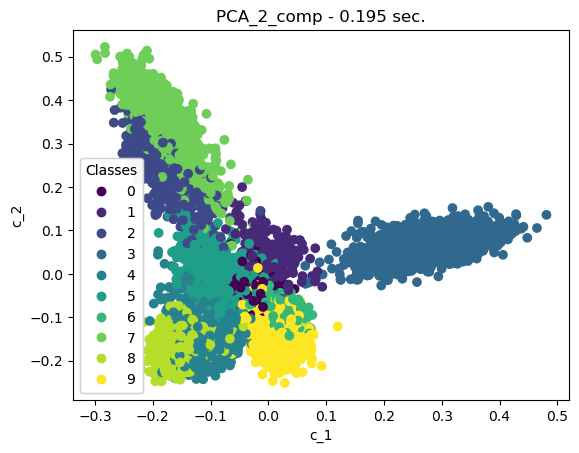

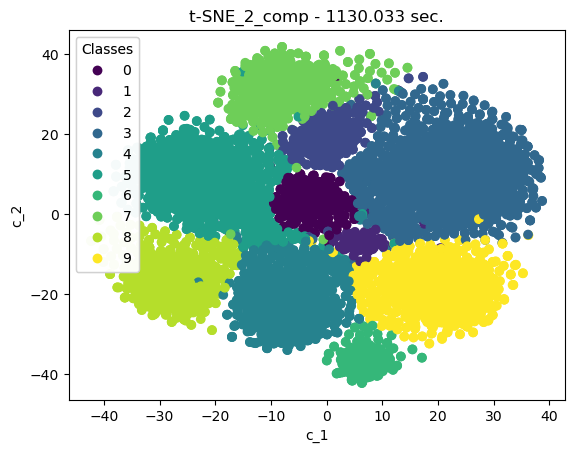

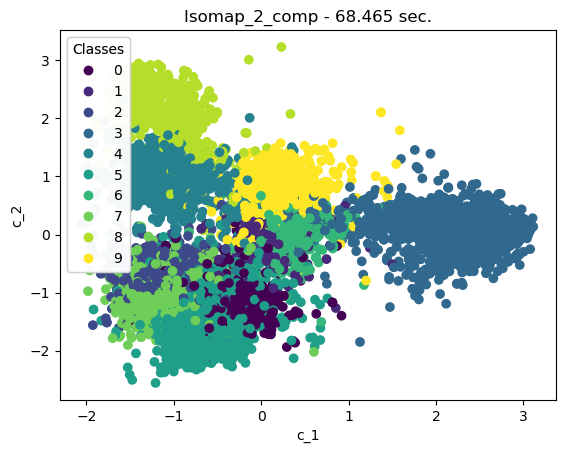

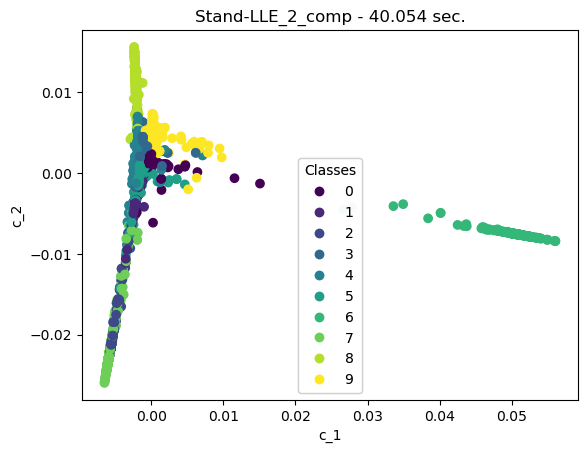

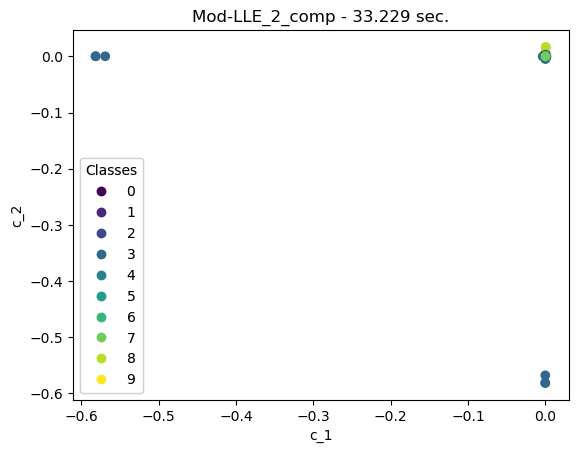

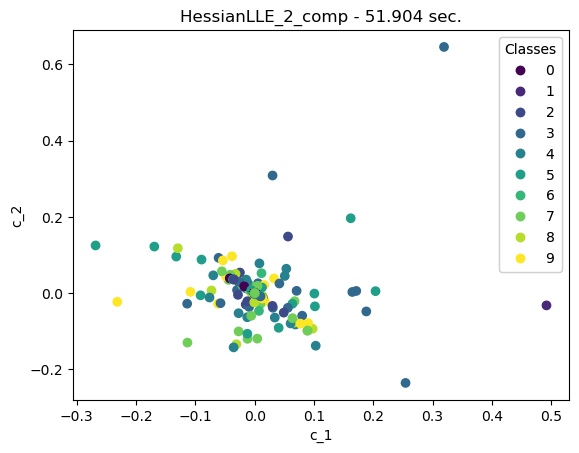

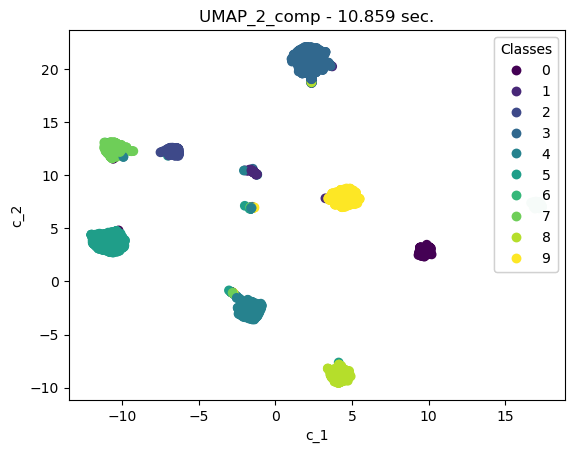

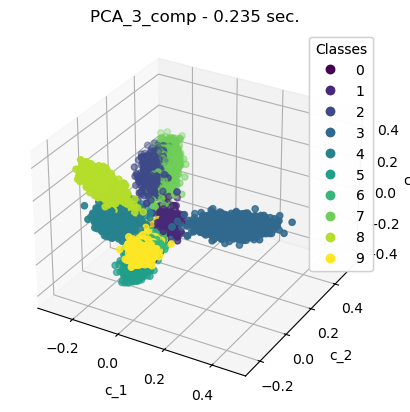

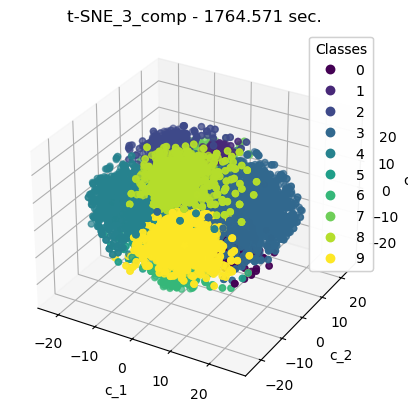

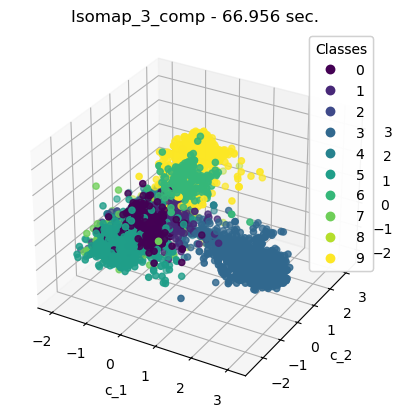

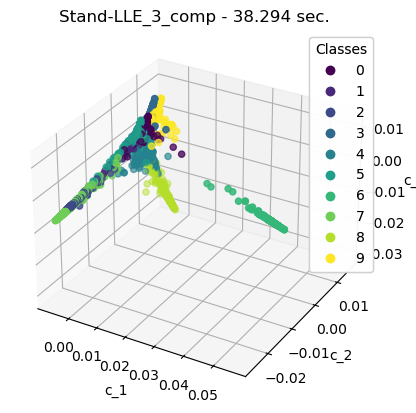

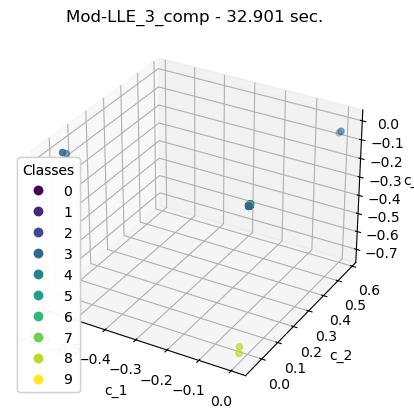

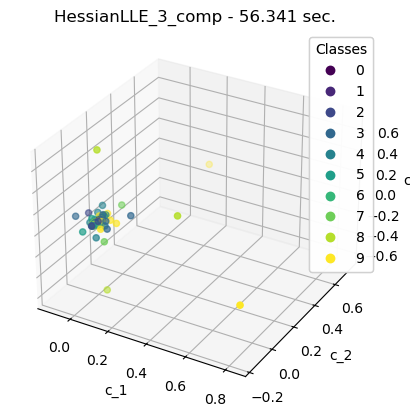

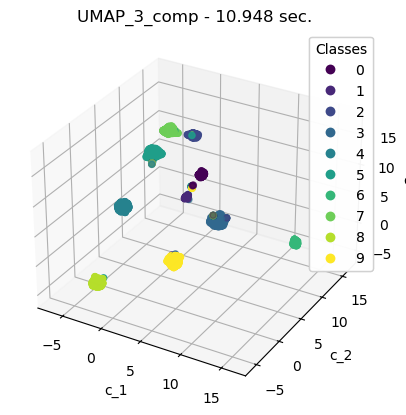

In [256]:
embeddings_dfs = {}
figs = []

# fit each embedding and create a dataframe of the results
for i in range(len(embeddings)):
    for title, model in embeddings[i].items():
        
        print(f"Fitting {title}...",end='', flush=True)
        t0 = time()
        X_reduced =  model.fit_transform(X)
        print("Done ✔️")
        fit_time = f" - {time() - t0:.3f} sec."
        X_reduced = X_reduced.T
        columns = [f"{title}_c_{i}" for i in range(1,i+3)]
        embedding_df = pd.DataFrame(X_reduced.T, columns=columns)
        embedding_df['case_num'] = df['case_num']
        if i < 2:
            figs.append(plot_embeddings(X_reduced, df['case_num'], title+fit_time, columns, model.n_components))
        embeddings_dfs[title] = embedding_df

We note from the figures below that separation and density among the clusters varies according to the embedding employed and the number of dimensions.

UMAP in 3 dimensions and T-SNE in 2 dimensions perform exceptionally well (at least from simply looking at the plots).

For reasons unknown to me (likely something to do with the data quantity), some of the plots, such as 2D PCA, do not render :'(

In [257]:
# print(f"Embedding DFs created:")
# [print(f"\t{key}") for key in embeddings_dfs.keys()]
# print()
# embeddings_dfs['PCA_3_comp']

## Clustering methods
I used **k-means** clustering to assess clustering performance. K-means is a centroid based method that partitions the data into k spherical clusters. 

I used 10 centroids (the same number as the number of cases). However, any number of centroids could be used, given that we're assuming that we don't actually have labeled data.

In the interest of time, I did not implement the following methods. However, these would have provided a better overall indication of clustering performance:
- **DBSCAN**: a density based method (grouping points that are closely packed together), better suited to arbitrarily shaped clusters with plenty of noise; it doesn't require a predefined number of clusters
- **Agglomerative clustering**: a bottom-up hierarchical partitioning of points that's tolerant to noise, though computationally expensive


In [258]:
n_clusters = 10
random_state = 42
kmeans_model = KMeans(n_clusters=n_clusters, random_state=random_state)

## Clustering metrics
I referenced [This scikit learn page](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation) in determining how to measure clustering performance. There are a few different methods to measure performance, but I went with the **silhoutte score.**

The silhouette score measures how well each sample in a cluster is separated from samples in other clusters. It takes into account both the cohesion (how close the samples are to each other within the same cluster) and the separation (how far the samples are from samples in other clusters). The silhouette score ranges from -1 to 1, where a higher value indicates better clustering. A score close to 1 suggests that the samples are well-clustered, while a score close to -1 indicates that the samples may have been assigned to the wrong clusters.

In [259]:
clusters = {}
for embedding_name, df in embeddings_dfs.items():
    # extract only components (i.e. no labels)
    X_1 = df.iloc[:,:-1]

    # fit clusters
    kmeans = kmeans_model.fit(X_1)
    
    # extract cluster labels
    kmeans_labels = kmeans.labels_

    silhouette_score = metrics.silhouette_score(X_1, kmeans_labels, metric='euclidean')
    clusters[embedding_name] = {
        "silhouette_score":silhouette_score,
        }

In [260]:
silhouette_scores = pd.DataFrame(clusters).T
silhouette_scores.columns = ['silhouette_score']
silhouette_scores = silhouette_scores.sort_values(by='silhouette_score', ascending=False)
silhouette_scores

,silhouette_score
HessianLLE_2_comp,0.991856
HessianLLE_4_comp,0.989373
HessianLLE_3_comp,0.987355
UMAP_4_comp,0.909119
UMAP_2_comp,0.905400
UMAP_3_comp,0.898546
Stand-LLE_4_comp,0.770970
Mod-LLE_2_comp,0.757436
Stand-LLE_2_comp,0.727098
Stand-LLE_3_comp,0.701370


In graphing the silhouette scores, we note that the embedding with the highest performance is Hessian LLE for 2, 3, and 4 dimensions, which are all very close to 1.0. All methods were >0, indicating that they all performed reasonable well on all dimension sizes. This suggests that after applying truncated SVD, the data were already fairly well separated in 213 dimensions, and that structure was held after the embeddings reduced this to 2 or 3 dimensions.

This result is a bit surprising, as the plots of these methods don't appear to be particularly well clustered. From the results obtained, the embedding method (and not the number of dimensions) is the determining factor in the silhouette score.

Overall, I would have liked to have spent more time in developing this code to obtained more assurance that the results I obtained are accurate. However, in the interest of time, I had to settle for this limited analysis.

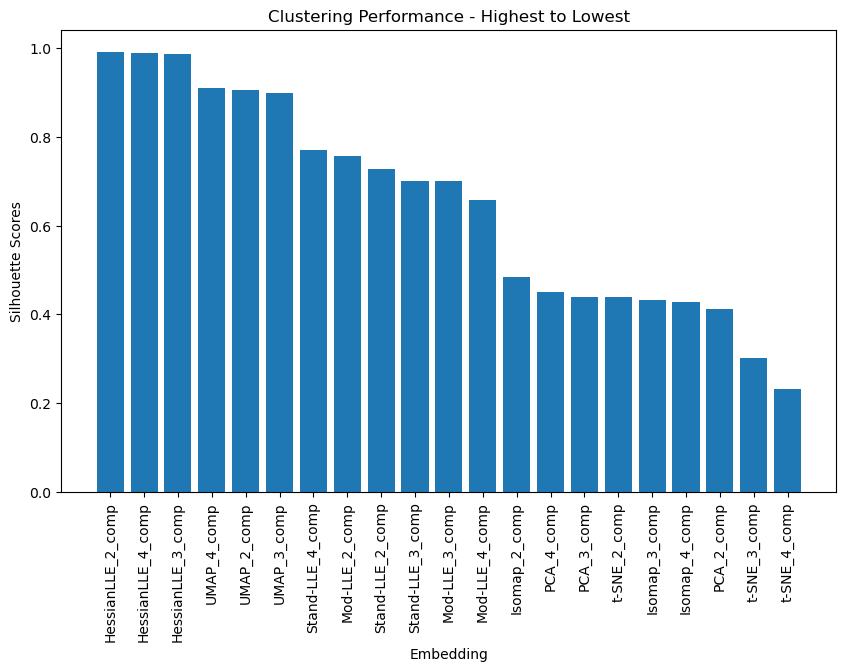

In [261]:
import matplotlib.pyplot as plt

# Plotting the silhouette scores
plt.figure(figsize=(10, 6))
plt.bar(silhouette_scores.index, silhouette_scores['silhouette_score'])
plt.title("Clustering Performance - Highest to Lowest")
plt.xlabel("Embedding")
plt.ylabel("Silhouette Scores")
plt.xticks(rotation=90)
plt.show()